In [ ]:
# Install transformers and thai2transformers
!pip install transformers
!pip install -q emoji pythainlp==2.2.4 sefr_cut tinydb seqeval sentencepiece pydantic jsonlines
!pip install --no-deps thai2transformers==0.1.2
!pip install evaluate

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datdasets import load_dataset, load_metric
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric
import matplotlib.pyplot as plt
import evaluate

In [3]:
# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
import pandas as pd
df = pd.read_csv('/kaggle/input/ticket/data.csv')
df.drop(columns=['Unnamed: 0'])
df['text'] = df['clean_subject'] + ' ' + df['clean_description']

In [5]:
data = df[['ticket_type','text']]
data = data[data['ticket_type'] != 'Problem'] #Drop Class Problem
data.dropna(subset=['text'], inplace=True)

In [6]:
# Encode labels as integers
label2id = {'Incident': 0, 'Request': 1}
data['labels'] = data['ticket_type'].map(label2id)

In [7]:
# Sample 50,000 from each class
df_request = data[data['ticket_type'] == 'Request'].sample(n=50000, random_state=42)
df_incident = data[data['ticket_type'] == 'Incident'].sample(n=50000, random_state=42)
df_balanced = pd.concat([df_request, df_incident]).reset_index(drop=True)

In [8]:
# Split the data into train+val and test sets
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df_balanced['text'].tolist(), df_balanced['labels'].tolist(), test_size=0.2, random_state=42)

# Further split train+val into train and val sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.25, random_state=42)


In [15]:
print(df_balanced['ticket_type'].value_counts())

ticket_type
Request     50000
Incident    50000
Name: count, dtype: int64


In [16]:
# Tokenize data
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels})

In [21]:
from transformers import TrainingArguments, EarlyStoppingCallback

# Define training arguments with matching strategies
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",         # Save every epoch
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1000,
    load_best_model_at_end=True,   # Required for early stopping
    metric_for_best_model="accuracy",
    greater_is_better=True,
)


In [22]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

# Load metric
accuracy_metric = evaluate.load("accuracy")

# Custom callback for collecting loss and accuracy
class CustomCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        output = trainer.evaluate(eval_dataset=val_dataset)
        self.losses.append(output["eval_loss"])
        self.accuracies.append(output["eval_accuracy"])

# Initialize the callback
callback = CustomCallback()

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {"accuracy": accuracy_metric.compute(predictions=p.predictions.argmax(-1), references=p.label_ids)["accuracy"]},
    callbacks=[callback, EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
#rm -rf ~/.cache/huggingface

In [23]:
# Train the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,0.155600,0.144960,0.966200
2,0.111800,0.141896,0.967100
3,0.101800,0.138225,0.967900


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=22500, training_loss=0.13502900882297092, metrics={'train_runtime': 17371.5758, 'train_samples_per_second': 10.362, 'train_steps_per_second': 1.295, 'total_flos': 4.73599899648e+16, 'train_loss': 0.13502900882297092, 'epoch': 3.0})

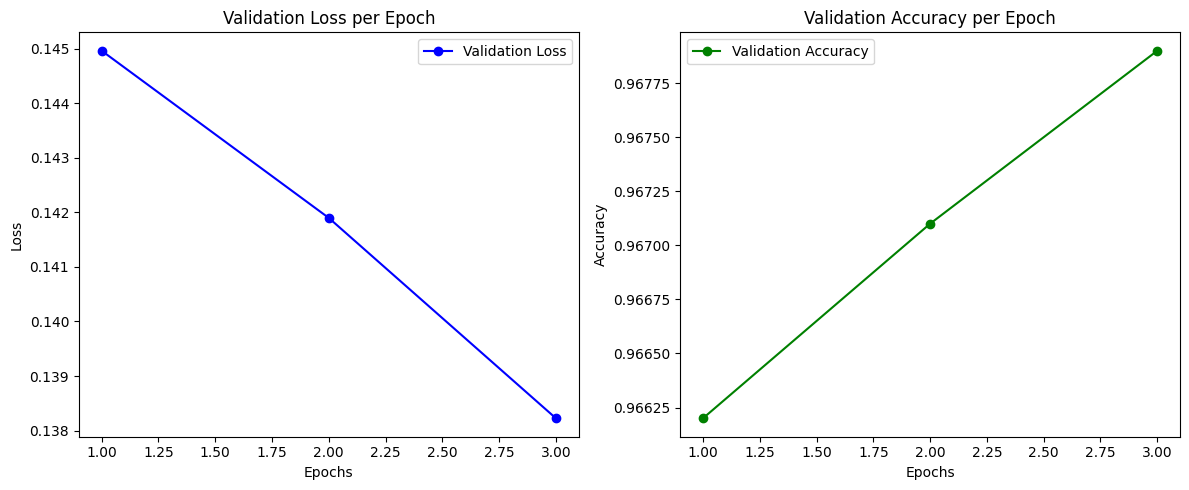

In [24]:
# Plot loss and accuracy
epochs = range(1, len(callback.losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, callback.losses, 'bo-', label='Validation Loss')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, callback.accuracies, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

In [25]:
# Evaluate the model on validation set
val_results = trainer.evaluate(eval_dataset=val_dataset)
print("Validation results:", val_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Validation results: {'eval_loss': 0.13822461664676666, 'eval_accuracy': 0.9679, 'eval_runtime': 600.3479, 'eval_samples_per_second': 33.314, 'eval_steps_per_second': 4.164, 'epoch': 3.0}


In [ ]:
# # Evaluate the model on test set
# test_results = trainer.evaluate(eval_dataset=test_dataset)
# print("Test results:", test_results)

In [26]:
# Save the trained model
trainer.save_model('model')

In [20]:
# Load the model for prediction (if needed)
model = XLMRobertaForSequenceClassification.from_pretrained('model')
tokenizer = XLMRobertaTokenizer.from_pretrained('model')

In [22]:
!pip install safetensors

In [25]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

# Load the model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('model')
tokenizer = XLMRobertaTokenizer.from_pretrained('model')

# Specify the directory to save
model_dir = "./model"

# Save the model in the default format
model.save_pretrained(model_dir)

## Performance on TestDataset

In [28]:
# Check class balance in test_dataset
test_labels = test_dataset['labels']  # Adjust this if your dataset structure is different
class_balance = pd.Series(test_labels).value_counts()
print("Class Balance in Test Dataset:")
print(class_balance)

Class Balance in Test Dataset:
1    10035
0     9965
Name: count, dtype: int64


In [29]:
from sklearn.metrics import classification_report

# Get predictions
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)

# Assuming you have the true labels in the test dataset
true_labels = test_dataset['labels']  # Adjust this if your dataset structure is different

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=['Incident', 'Request'])
print("Classification Report:")
print(report)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
              precision    recall  f1-score   support

    Incident       0.96      0.98      0.97      9965
     Request       0.98      0.96      0.97     10035

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



# Attention Visualization
> Shows which tokens the model is focusing on (if applicable).

In [14]:
!wget https://github.com/google/fonts/raw/main/ofl/thaisarabunnew/THSarabunNew-Bold.ttf -O /usr/share/fonts/truetype/thai/THSarabunNew-Bold.ttf

/usr/share/fonts/truetype/thai/THSarabunNew-Bold.ttf: No such file or directory


In [18]:
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import os
import requests

# Load the trained model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained('model', output_attentions=True)
tokenizer = XLMRobertaTokenizer.from_pretrained('model')

# Tokenize the sample text
sample_text = "noc alert ได้รับ"
tokens = tokenizer(sample_text, return_tensors='pt', truncation=True, padding=True, max_length=512)

# Get model output including attentions
outputs = model(**tokens)
attentions = outputs.attentions  # attentions is a tuple of (num_layers, batch_size, num_heads, seq_length, seq_length)

# Process and visualize attention weights
attention_weights = attentions[0][0][0].detach().cpu().numpy()  # (seq_length, seq_length)
tokens_list = tokenizer.convert_ids_to_tokens(tokens['input_ids'].squeeze().tolist())

# Define the font path
font_path = 'THSarabunNew-Bold.ttf'
font_url = "https://github.com/google/fonts/raw/main/ofl/thaisarabunnew/THSarabunNew-Bold.ttf"

# Download the Thai font if not exists
if not os.path.exists(font_path):
    response = requests.get(font_url)
    if response.status_code == 200:
        with open(font_path, 'wb') as f:
            f.write(response.content)
    else:
        raise Exception("Failed to download font")

# Verify the font file size
if os.path.getsize(font_path) == 0:
    raise Exception("Downloaded font file is empty")

# Add the font to matplotlib
fm.fontManager.addfont(font_path)
prop = fm.FontProperties(fname=font_path)

# Create heatmap with Thai font
sns.heatmap(attention_weights, xticklabels=tokens_list, yticklabels=tokens_list, cmap="viridis")
plt.xticks(fontproperties=prop, rotation=90)
plt.yticks(fontproperties=prop, rotation=0)
plt.show()


Exception: Downloaded font file is empty